In [ ]:
#!conda install -c pytorch pytorch
#!conda install -c conda-forge spacy
#!conda install -c pytorch torchtext


In [3]:
import torch
from torchtext import data

import pandas as pd
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import spacy

from torch.autograd import Variable

import time
import copy
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from torchtext.vocab import Vectors, GloVe
from matplotlib.pyplot import plot, hist, xlabel, legend

In [5]:
#Reading training, validation and test data from respective csv files
from google.colab import drive
drive.mount('/content/drive')
# path = "copied path"
# df_bonus = pd.read_csv(path)
train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DBPEDIA_train.csv")
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DBPEDIA_test.csv")
validation_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DBPEDIA_val.csv")
                        
#Displaying training data Head
train_data.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,text,l1,l2,l3
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain
3,Cancer Prevention Research is a biweekly peer-...,Work,PeriodicalLiterature,AcademicJournal
4,The Princeton University Chapel is located on ...,Place,Building,HistoricBuilding


In [6]:
#Removing any sort of urls from the dataframes

import re
url = re.compile(r'https?://\S+|www\.\S+')
train = train_data['text'].apply(lambda news: url.sub(r'',news))
test = test_data['text'].apply(lambda news: url.sub(r'',news))
valid = validation_data['text'].apply(lambda news: url.sub(r'',news))

In [7]:
#Removing the noise from data and transforming them to lowercase

train=train.str.lower().str.replace("[^a-z]", " ")
test=test.str.lower().str.replace("[^a-z]", " ")
valid=valid.str.lower().str.replace("[^a-z]", " ")

In [8]:
#Removing the stop-words and performing lemmatization

tokenized_train = train.apply(lambda news: news.split())
tokenized_test = test.apply(lambda news: news.split())
tokenized_val = valid.apply(lambda news: news.split())


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

tokenized_train = tokenized_train.apply(lambda news: [lem.lemmatize(word) for word in news if word not in stop_words])
tokenized_test = tokenized_test.apply(lambda news: [lem.lemmatize(word) for word in news if word not in stop_words])
tokenized_val = tokenized_val.apply(lambda news: [lem.lemmatize(word) for word in news if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [9]:
#De-tokenizing data 

detokenized_train = [] 
for i in range(len(train)): 
    t = ' '.join(tokenized_train[i]) 
    detokenized_train.append(t) 

detokenized_test = [] 
for i in range(len(test)): 
    t = ' '.join(tokenized_test[i]) 
    detokenized_test.append(t) 

detokenized_val = [] 
for i in range(len(valid)): 
    t = ' '.join(tokenized_val[i]) 
    detokenized_val.append(t) 

train_data['text'] = detokenized_train
test_data['text'] = detokenized_test
validation_data['text'] = detokenized_val

#Displaying Preety datasets
train_data.head()
#test_data.head()
#validation_data.head()

,text,l1,l2,l3
0,william alexander massey october march united ...,Agent,Politician,Senator
1,lion sixth studio album american rock band bla...,Work,MusicalWork,Album
2,pirqa aymara quechua wall hispanicized spellin...,Place,NaturalPlace,Mountain
3,cancer prevention research biweekly peer revie...,Work,PeriodicalLiterature,AcademicJournal
4,princeton university chapel located university...,Place,Building,HistoricBuilding


In [11]:
#Selecting text and label field
train = train_data[['text', 'l2']]
valid = validation_data[['text', 'l2']]
test = test_data[['text']]

X_train = train['text']
y_train = train['l2']
X_val = valid['text']
y_val = valid['l2']

train_data = pd.concat([X_train, y_train], axis=1)
validation_data = pd.concat([X_val, y_val], axis=1)

In [30]:
#!pip install torch torchvision

ERROR: Could not find a version that satisfies the requirement torch.backends.cudnn (from versions: none)
ERROR: No matching distribution found for torch.backends.cudnn


In [12]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda Status on system is True


(array([1.42659e+05, 5.88460e+04, 2.32950e+04, 1.00850e+04, 4.38300e+03,
        1.51900e+03, 1.34000e+02, 1.90000e+01, 1.00000e+00, 1.00000e+00]),
 array([  4. ,  53.4, 102.8, 152.2, 201.6, 251. , 300.4, 349.8, 399.2,
        448.6, 498. ]),
 <a list of 10 Patch objects>)

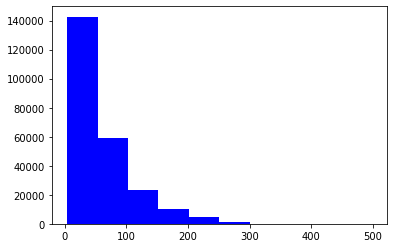

In [13]:
news_len=train['text'].str.split().map(lambda x: len(x))
hist(news_len,color='blue')

In [15]:
train_data.to_csv("processed_files/train.csv", index=False)
validation_data.to_csv("processed_files/val.csv", index=False)

In [43]:
fix_length = 250
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [44]:
train_data, val_data = data.TabularDataset.splits(
    path="processed_files/", train="train.csv", 
    test="val.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [45]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(val_data)}')

Number of training examples: 240942
Number of testing examples: 36003


In [46]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 394137
Unique tokens in LABEL vocabulary: 70


In [47]:
batch_size = 16
 
train_iterator, val_iterator = data.BucketIterator.splits(
    (train_data, val_data), sort_key=lambda x: len(x.Text),
    batch_size=batch_size,
    device=device)

In [48]:
class LSTM2DMaxPoolClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, weights):
		super(LSTM2DMaxPoolClassifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		self.hidden_size = hidden_size
		self.batch_size = batch_size
		self.num_layers = num_layers
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size, num_layers, batch_first = True)
		self.maxpool = nn.MaxPool1d(4) # Where 4 is kernal size
		self.label = nn.Linear(hidden_size//4, output_size)  #//4 for maxpool
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
		  h_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM, num_layers*2 for biderection
		  c_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM, num_layers*2 for biderection
		else:
			h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))

		pooled = self.maxpool(output)

		final_output = self.label(pooled[:, -1, :]) #the same if we would use final_hidden_state

		return final_output

In [50]:
word_embeddings = TEXT.vocab.vectors
output_size = 2
num_layers = 3
hidden_size = 32
embedding_length = 300
vocab_size = len(TEXT.vocab)

In [51]:
model = LSTM2DMaxPoolClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

In [52]:
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [53]:
model = model.to(device)
criterion = criterion.to(device)

In [54]:
dataiter_dict = {'train': train_iterator, 'val': val_iterator}
dataset_sizes = {'train':len(train_data), 'val':len(val_data)}

In [55]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 200

    val_loss = []
    train_loss = []
    val_acc = []
    train_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            sentiment_corrects = 0
            tp = 0.0
            tn = 0.0
            fp = 0.0
            fn = 0.0
                      
            # Iterate over data.
            for batch in dataiter_dict[phase]:
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    text = batch.Text
                    label = batch.Label
                    label = torch.autograd.Variable(label).long()
                    if torch.cuda.is_available():
                      text = text.cuda()
                      label = label.cuda()
                    if (batch.Text.size()[1] is not batch_size):
                      continue
                    
                    outputs = model(text)

                    outputs = F.softmax(outputs,dim=-1)
                    
                    loss = criterion(outputs, label)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * text.size(0)
                sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == label)

                tp += torch.sum(torch.max(outputs, 1)[1] & label)
                tn += torch.sum(1-torch.max(outputs, 1)[1] & 1-label)
                fp += torch.sum(torch.max(outputs, 1)[1] & 1-label)
                fn += torch.sum(1-torch.max(outputs, 1)[1] & label)

                
            epoch_loss = running_loss / dataset_sizes[phase]
 
            sentiment_acc = sentiment_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc.append(sentiment_acc)
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(sentiment_acc)
                val_loss.append(epoch_loss)

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} sentiment_acc: {:.4f}'.format(
                phase, sentiment_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'lstm_model_test.pth')

        print()

    confusion_matrix = [[tp, fp],[fn, tn]]
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(float(best_loss)))
    results = {'time': time_elapsed, 'conf_matr': confusion_matrix,
               'val_loss': val_loss, 'train_loss': train_loss, 'val_acc': val_acc, 'train_acc': train_acc}
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
#model_fit, res = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=8)
model_fit, res = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=8)

starting
Epoch 1/8
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


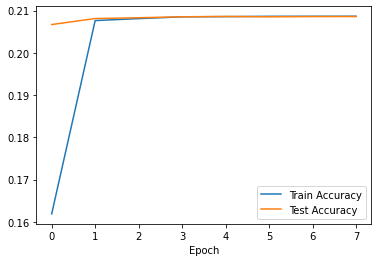

In [29]:
plot(res['train_acc'], label = 'Train Accuracy')
plot(res['val_acc'], label = 'Test Accuracy')
xlabel('Epoch')
legend()

In [ ]:
test.to_csv("processed_files/test.csv", index=False)

In [ ]:
test_data = data.TabularDataset(
    path="processed_files/test.csv", format="csv", skip_header=True, 
    fields=[('Text', TEXT)]
)

In [ ]:
print(f'Number of testing examples: {len(test_data)}')

In [ ]:
batch_size = 16

# keep in mind the sort_key option 
test_iterator = data.BucketIterator(
    test_data,
    train=False,
    sort = False,
    sort_within_batch=False,
    repeat=False,
    batch_size=batch_size,
    device=device)

In [ ]:
model.eval()
pred = []

for batch in test_iterator:
  text = batch.Text
  if torch.cuda.is_available():
    text = text.cuda()
  if (batch.Text.size()[1] is not batch_size):
    continue
  outputs = model(text)
  outputs = F.softmax(outputs,dim=-1)
  outputs = torch.max(outputs, 1)[1]
  pred.append(outputs.cpu().numpy())

In [ ]:
pred = np.array(pred)
pred = pred.reshape(-1)

In [ ]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sub = pd.concat([test['id'], pd.Series(pred, name='target')], axis=1)

In [ ]:
sub.head()

In [ ]:
sub = sub.fillna(0)

In [ ]:
sub = sub.astype(int)

In [ ]:
sub

In [ ]:
sub.to_csv('sub.csv', index=False)

In [ ]:
!head sub.csv